### ISYE 6741 - Machine Learning

**Homework 3 - Graham Billey**

#### 1. Order of Faces Using ISOMAP

The file `isomap.mat` contains 698 images corresponding to different poses of the same face. Each image is given as a $64$ x $64$ luminiosity map, hence represented as a vector in $\mathbb{R}^{4096}$. Each vector is stored as a row in the file. 

This dataset was used in the original paper for ISOMAP, J.B. Tenenbaum, V de Silva, and J.C. Langford, Science 290 (2000) 2319-2323.

In [2]:
# Import functions and load the data
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from scipy.io import loadmat
from sklearn.metrics import pairwise_distances
from sklearn.utils.graph_shortest_path import graph_shortest_path

data = loadmat('isomap.mat')['images'].T
pics, features = data.shape

#### a) Choose the Euclidean distance between images (in this case, a distance in $\mathbb{R}^{4096}$). Construct a similarity graph with vertices corresponding to the images, and tune the threshold $\epsilon$ so that each node has at least 100 neighbors. Visualize the similarity graph (e.g. plot the adjacency matrix, or visualize the graph and illustrate a few images corresponding to nodes at different parts of the graph).

In [3]:
l = 2 # Norm

# Calculate pairwise distances between all points. This should be a 698x698 array.
A = np.zeros(shape=(pics, pics))
for row1 in range(pics):
    for row2 in range(row1):
        dist = np.linalg.norm(data[row1,:]-data[row2,:], ord=l)
        A[row1, row2] = dist
        A[row2, row1] = dist
# Equivalently...
# A = pairwise_distances(data, metric = 'euclidean') 

# Find the epsilon value where each node has at least 100 neighbors.
min_neighbors = 0
eps = 10 # Starting point for epsilon
while min_neighbors < 100:
    eps += 1
    A_n = A.copy()
    A_n[A > eps] = np.inf
    min_neighbors = min(np.sum(np.isfinite(A_n), axis=1))
print(f'Epsilon: {eps}, Minimum neighbors: {min_neighbors}')


Epsilon: 23, Minimum neighbors: 135


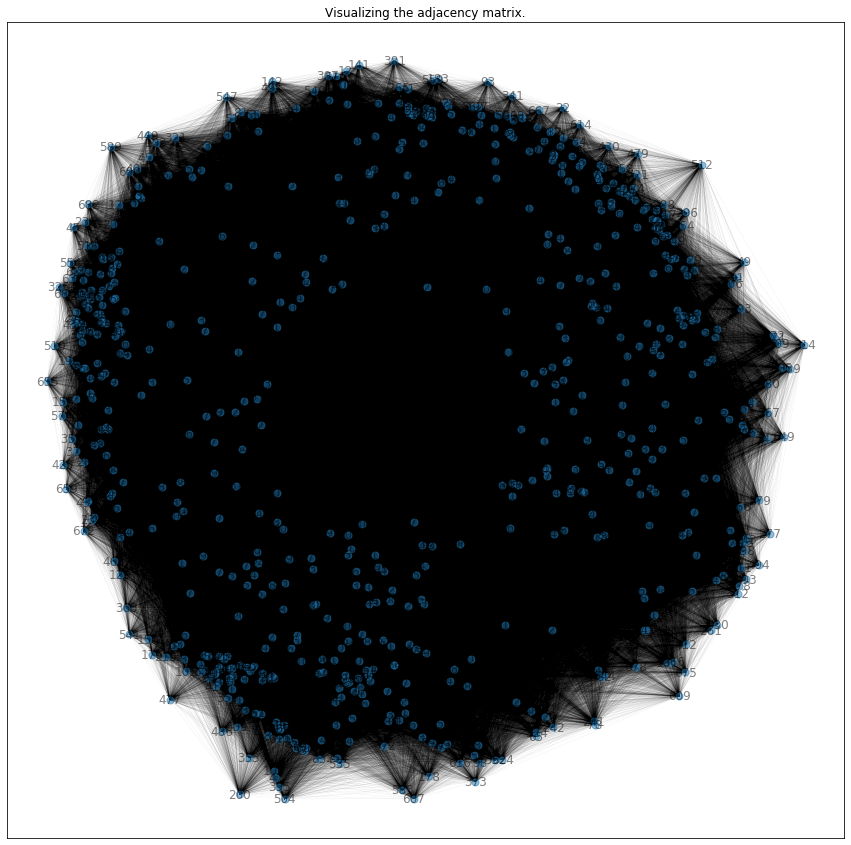

In [4]:
# Plot the adjacency matrix
G = nx.Graph(A)
fig = plt.figure(figsize=(15,15))
nx.draw_networkx(G, node_size=50, alpha=0.5, width=0.05)
plt.title('Visualizing the adjacency matrix.')
plt.show()

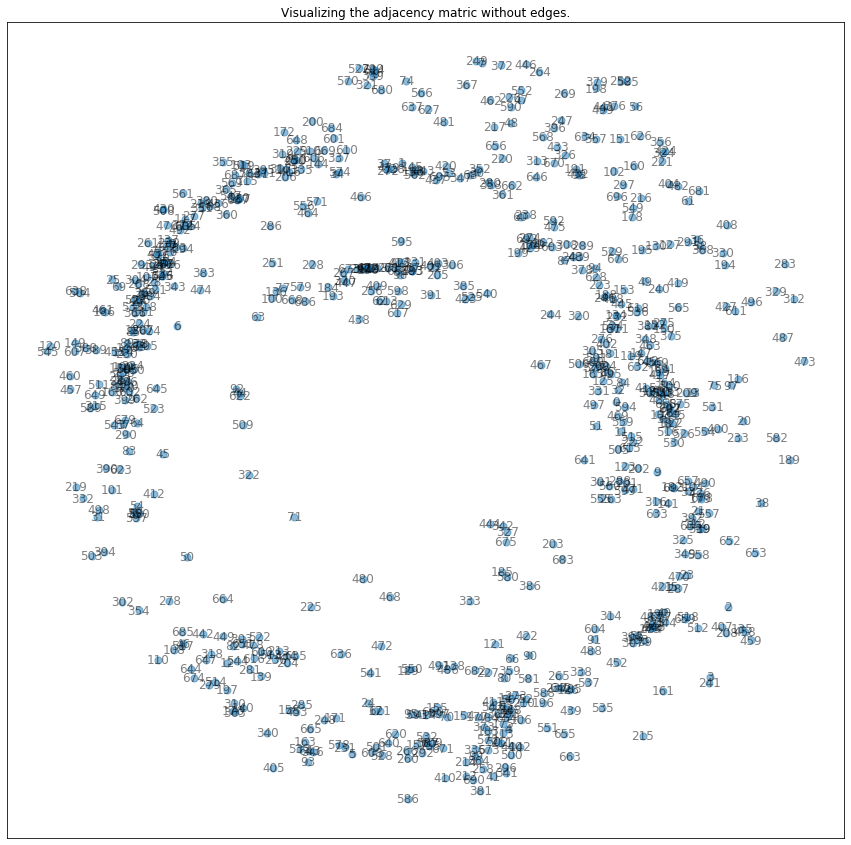

In [5]:
# Plot the adjacency matrix - Remove the edges
fig = plt.figure(figsize=(15,15))
nx.draw_networkx(G, node_size=50, alpha=0.5, width=0)
plt.title('Visualizing the adjacency matric without edges.')
plt.show()

Four images that appear close together in the network graph.


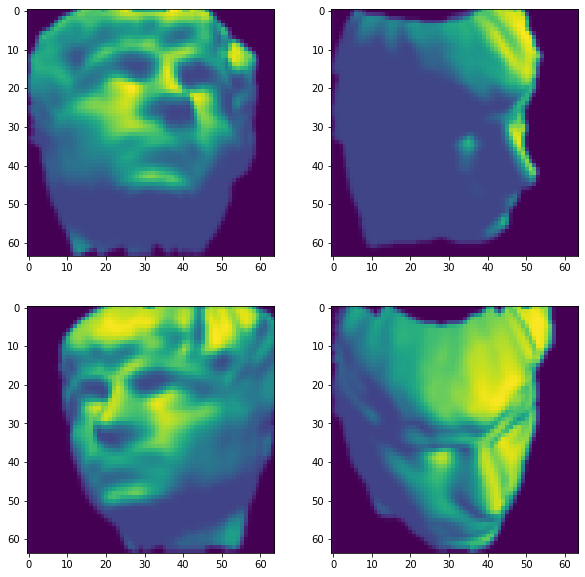

In [6]:
# Show a few images (nodes 476, 466, 504, and 542, which are "near" each other at the top of the above image)
examples = [476, 466, 504, 542]

fig = plt.figure(figsize=(10,10))
for i in range(4):
    ax = fig.add_subplot(2,2,i+1)
    imgplot = ax.imshow(np.reshape(data[examples[i]], (64,64), order='F'))
    
print('Four images that appear close together in the network graph.')
plt.show()

Although these images are near each other according to the adjacency matrix, only images 466 and 542 show the face in the same orientation and lighting.

#### b) Implement the ISOMAP algorithm and apply it to this graph to obtain a $d = 2$-dimensional embedding. Present a plot of this embedding. Find 3 points that are "close" to each other in the embedding space, and show what they look like. Do you see anny visual similarity among them?

In [7]:
# Compute the shortest-distance matrix D
D = graph_shortest_path(A_n, directed=False)

# Calculate the centering matrix, H
H = np.identity(pics) - (1/pics)*np.ones(shape=(pics, pics))

# Calculate the matrix C
D2 = np.multiply(D, D)
C = -1/(2*pics) * H @ D2 @ H

# Compute the eigendecomposition of C
vals, vecs = np.linalg.eigh(C)
val1 = vals[-1]
val2 = vals[-2]
vec1 = vecs[:,-1]
vec2 = vecs[:,-2]

# Project each picture onto the eigenspace
Z = np.concatenate([vec1*np.sqrt(val1), vec2*np.sqrt(val2)]).reshape(-1,2, order='F')


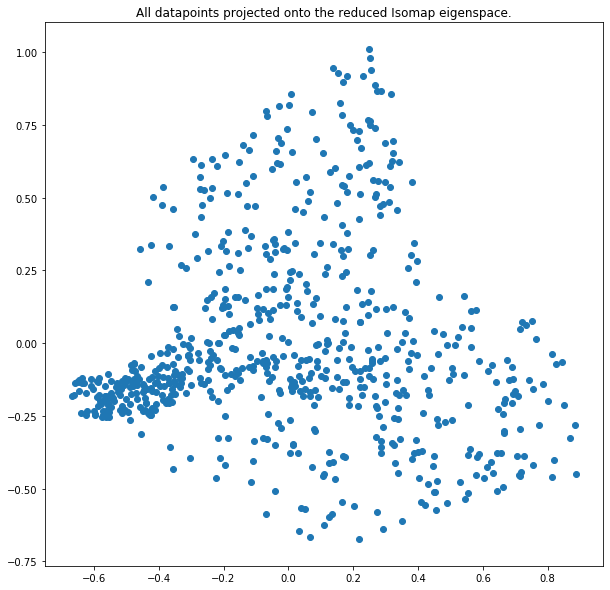

In [8]:
# Show the datapoints projected onto the eigenspace
fig = plt.figure(figsize=(10,10))
plt.scatter(Z[:,0], Z[:,1])
plt.title('All datapoints projected onto the reduced Isomap eigenspace.')
plt.show()

In [9]:
def pick_samples(Z, h, v):
        xr = np.linspace(np.min(Z[:,0]), np.max(Z[:,0]), h)
        yr = np.linspace(np.min(Z[:,1]), np.max(Z[:,1]), v)
        xg, yg = np.meshgrid(xr, yr)
        
        indices = [0]*h*v
        
        for i, x, y in zip(range(h*v), xg.flatten(), yg.flatten()):
            indices[i] = int(np.sum(np.abs(Z - np.array([x, y]))**2, axis=-1).argmin())
            
        return indices

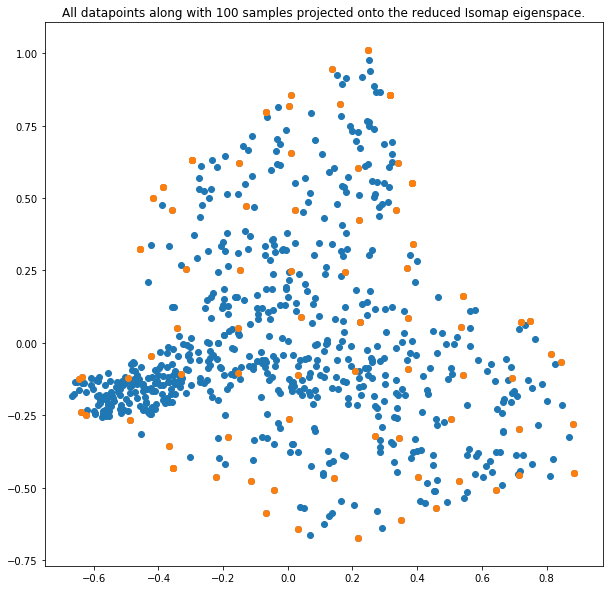

In [10]:
# Show the datapoints projected onto the eigenspace along with the 100 samples
samples = pick_samples(Z, 10, 10)
fig = plt.figure(figsize=(10,10))
plt.scatter(Z[:,0], Z[:,1])
plt.scatter(Z[samples, 0], Z[samples, 1]) # Samples are shown in orange
plt.title('All datapoints along with 100 samples projected onto the reduced Isomap eigenspace.')
plt.show()

Images corresponding to the 100 datapoints samples across the reduced Isomap eigenspace.


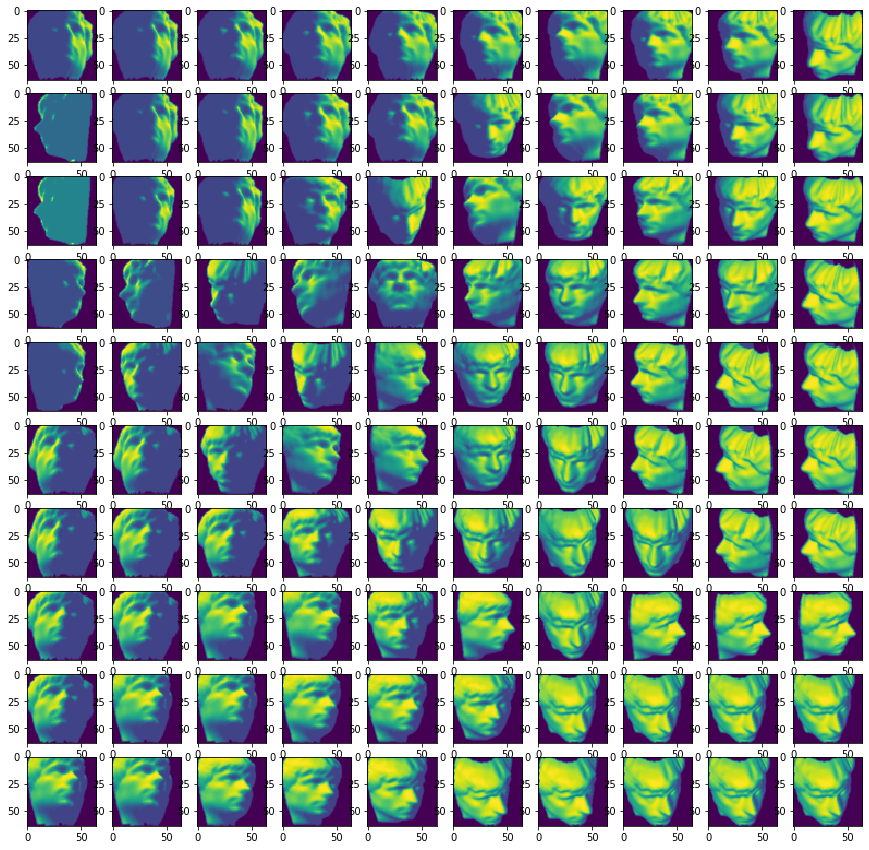

In [11]:
# Show the images corresponding to the samples
fig = plt.figure(figsize=(15, 15))
for i in range(len(samples)):
    ax = fig.add_subplot(10, 10, i+1)
    imgplot = ax.imshow(np.reshape(data[samples[i]], (64,64), order='F'))
    imgplot.set_interpolation('nearest')
    
print('Images corresponding to the 100 datapoints samples across the reduced Isomap eigenspace.')
plt.show()

The images do appear to be organized in the reduced Isomap eigenspace in a meaningful way. 

The original paper states **_"all of the images lie on an intrinsically three-dimensional manifold, or constant surface, that can be parameterized by two pose variations plus an azimuthal lighting angle. Our goal is to discover, given only the unordered high-dimensional inputs, low-dimensional representations ... that capture the intrinsic degrees of freedom of the data set."_**

This algorithm did a better job capturing the lighting angle than it did the various pose variations, although the poses are still grouped in local clusters. 

Along the (-) end of the first eigenvector, and the (+) end of the second eigenvector, are primarily found images with very little light. In the opposite direction are images with the most light. 

In general, it appears that we move from looking up at the image, to looking down on the image, as we move from the (-) end to the (+) end of the first eigenvector. 

In general, it appears that we move from looking at the right side of the image's face, to looking at the left side of the image's face, as we move from the (-) end to the (+) end of the second eigenvector.

**c) Now choose the $l_1$ (Manhatan) distance between images and repeat the steps above. Present a plot of this embedding. Do you see any difference by choosing a different similarity measure?**

In [12]:
l = 1
# Calculate pairwise distances between all points. This should be a 698x698 array.
A = np.zeros(shape=(pics, pics))
for row1 in range(pics):
    for row2 in range(row1):
        dist = np.linalg.norm(data[row1,:]-data[row2,:], ord=l)
        A[row1, row2] = dist
        A[row2, row1] = dist
# Equivalently...
# A = pairwise_distances(data, metric = 'manhattan') 

# Find the epsilon value where each node has at least 100 neighbors.
min_neighbors = 0
eps = 10 # Starting point for epsilon
while min_neighbors < 100:
    eps += 1
    A_n = A.copy()
    A_n[A > eps] = np.inf
    min_neighbors = min(np.sum(np.isfinite(A_n), axis=1))
print(f'Epsilon: {eps}, Minimum neighbors: {min_neighbors}')

Epsilon: 1009, Minimum neighbors: 100


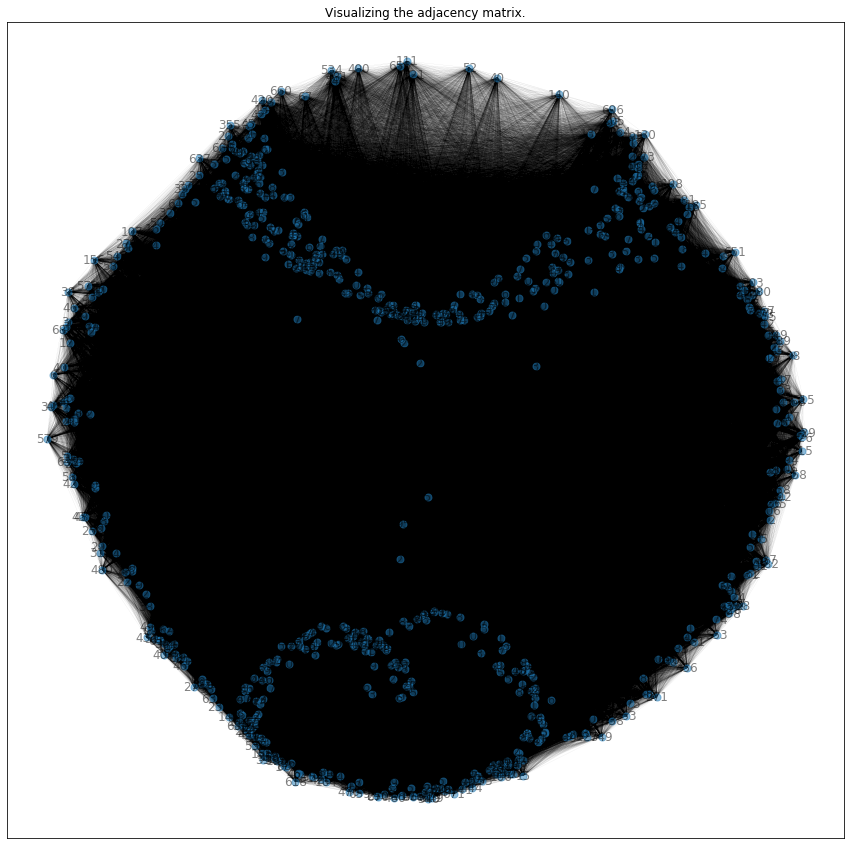

In [13]:
# Plot the adjacency matrix
G = nx.Graph(A)
fig = plt.figure(figsize=(15,15))
nx.draw_networkx(G, node_size=50, alpha=0.5, width=0.05)
plt.title('Visualizing the adjacency matrix.')
plt.show()

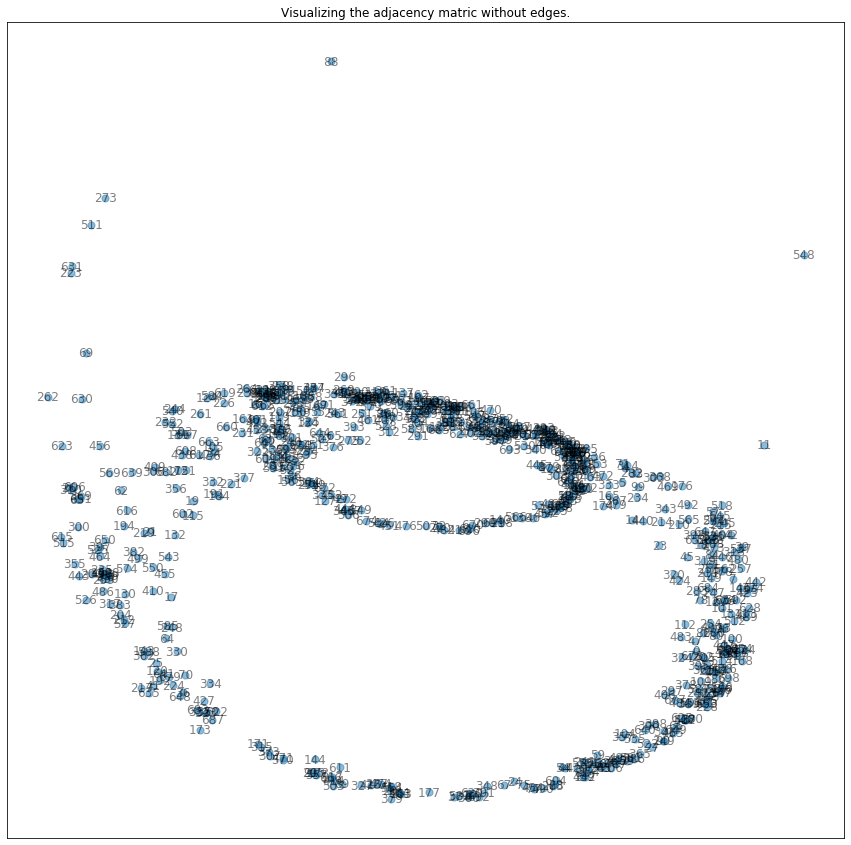

In [14]:
# Plot the adjacency matrix - Remove the edges
fig = plt.figure(figsize=(15,15))
nx.draw_networkx(G, node_size=50, alpha=0.5, width=0)
plt.title('Visualizing the adjacency matric without edges.')
plt.show()

Four images that appear close together in the network graph.


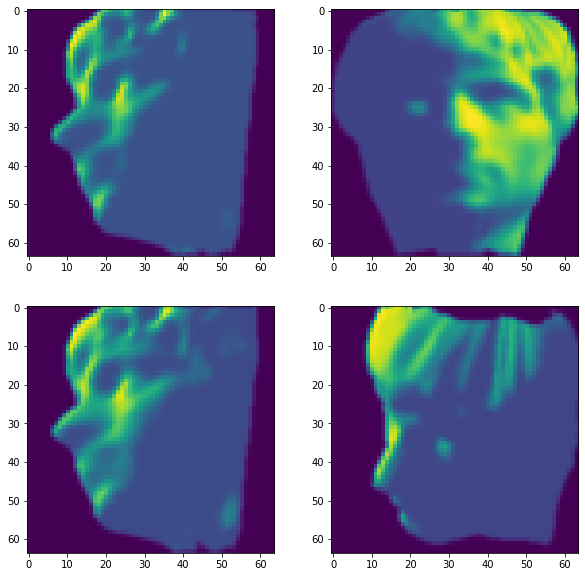

In [15]:
# Show a few images (nodes 310, 209, 182, and 551, which are "near" each other at the top of the above image)
examples = [310, 209, 182, 551]

fig = plt.figure(figsize=(10,10))
for i in range(4):
    ax = fig.add_subplot(2,2,i+1)
    imgplot = ax.imshow(np.reshape(data[examples[i]], (64,64), order='F'))
    
print('Four images that appear close together in the network graph.')
plt.show()

These images appear more similar to each other than the 4 images chosen using the euclidean distance. This suggests that manhattan distance might perform better than euclidean distance in clustering this dataset.

In [16]:
# Compute the shortest-distance matrix D
D = graph_shortest_path(A_n, directed=False)

# Calculate the centering matrix, H
H = np.identity(pics) - (1/pics)*np.ones(shape=(pics, pics))

# Calculate the matrix C
D2 = np.multiply(D, D)
C = -1/(2*pics) * H @ D2 @ H

# Compute the eigendecomposition of C
vals, vecs = np.linalg.eigh(C)
val1 = vals[-1]
val2 = vals[-2]
vec1 = vecs[:,-1]
vec2 = vecs[:,-2]

# Project each picture onto the eigenspace
Z = np.concatenate([vec1*np.sqrt(val1), vec2*np.sqrt(val2)]).reshape(-1,2, order='F')


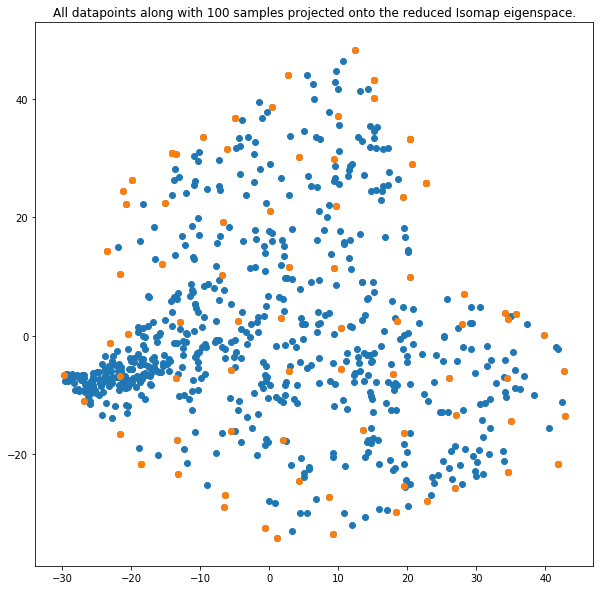

In [17]:
# Show the datapoints projected onto the eigenspace along with the 100 samples
samples = pick_samples(Z, 10, 10)
fig = plt.figure(figsize=(10,10))
plt.scatter(Z[:,0], Z[:,1])
plt.scatter(Z[samples, 0], Z[samples, 1]) # Samples are shown in orange
plt.title('All datapoints along with 100 samples projected onto the reduced Isomap eigenspace.')
plt.show()

Images corresponding to the 100 datapoints samples across the reduced Isomap eigenspace.


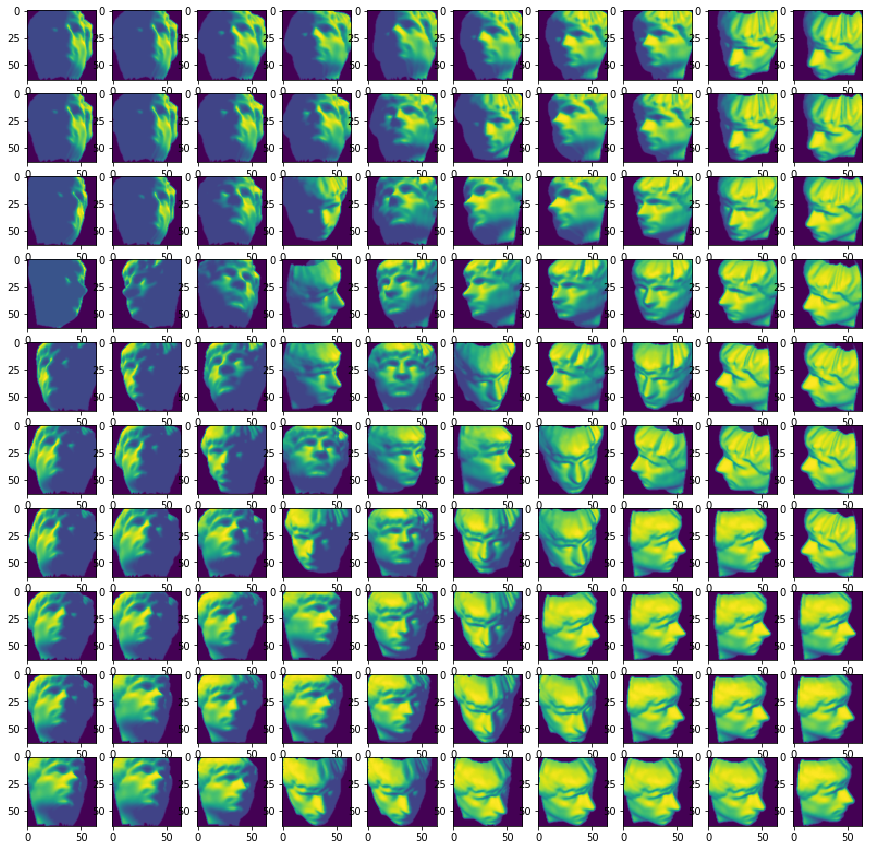

In [18]:
# Show the images corresponding to the samples
fig = plt.figure(figsize=(15, 15))
for i in range(len(samples)):
    ax = fig.add_subplot(10, 10, i+1)
    imgplot = ax.imshow(np.reshape(data[samples[i]], (64,64), order='F'))
    imgplot.set_interpolation('nearest')
    
print('Images corresponding to the 100 datapoints samples across the reduced Isomap eigenspace.')
plt.show()

In general, the embeddings appear to be very similar, both in accuracy and in the intrinsic dimensions captured by each eigenvalue.

We still move from looking up at the image to looking down at the image as we increase along the first eigenvector. We still move from looking at the right side of the image's face to looking at the left side of the image's face as we increase along the second eigenvector. The dimension corresponding to the lighting angle still appears to be the dimension that is best captured by this method, and the pattern of representation is the same as with Euclidean distance.

A few noticeable differences appear in the bottom few rows, where the faces on the (+) end of the first eigenvector are turned much more than previously. In fact, I would say that this distance measure better captured the face rotation better than the previous method.

The most noticeable difference between these methods is in the visualization of the adjacency matrix.

#### 2. Density Estimation: Psychological Experiments

The data set `n90pol.csv` contains information on 90 university students who participated in a psychological experiment designed to look for relationships between the size of different regions of the brain and political views. 

The variables `amygdala` and `acc` indicate the volume of two particular brain regions known to be involved in emotions and decision-making, the amygdala and the anterior cingulate cortex; more exactly, these are residuals from the predicted volume, after adjusting for height, sex, and similar body-type variables. 

The variable `orientation` gives the students’ locations on a five-point scale from `1 (very conservative)` to `5 (very liberal)`.

In [23]:
# Import functions and load the data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import hist2d
from matplotlib import cm
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D

dat = pd.read_csv('n90pol.csv')
data = dat.values

print('data has shape: ', dat.shape)
display(dat.head())

data has shape:  (90, 3)


,amygdala,acc,orientation
0,0.0051,-0.0286,2
1,-0.0674,0.0007,3
2,-0.0257,-0.0110,3
3,0.0504,-0.0167,2
4,0.0125,-0.0005,5


**a) Form a 2-dimensional histogram for the pairs of variables `amygdala` and  `acc`. Decide on a suitable number of bins so you can see the shape of the distribution clearly.**

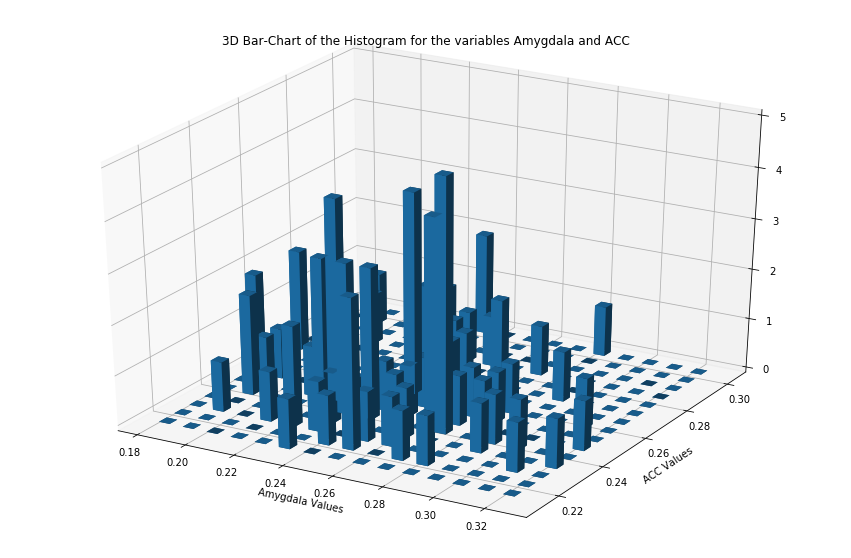

In [26]:
bins_per_axis = 15

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')
ax.set_title('3D Bar-Chart of the Histogram for the variables Amygdala and ACC')
ax.set_xlabel('Amygdala Values')
ax.set_ylabel('ACC Values')

hist, xedges, yedges = np.histogram2d(data[:,0], data[:,1], bins=bins_per_axis)

# Construct arrays for the anchor positions of the bars.
xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
xpos = xpos.flatten()
ypos = ypos.flatten()
zpos = 0

# Construct arrays with the dimensions for the bars.
dx = 1/bins_per_axis**2 * np.ones_like(zpos)
dy = 0.7/bins_per_axis**2 * np.ones_like(zpos)
dz = hist.ravel()

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average')

plt.show()

This isn't very easy to interpret, so we'll plot the same information using a heat map.

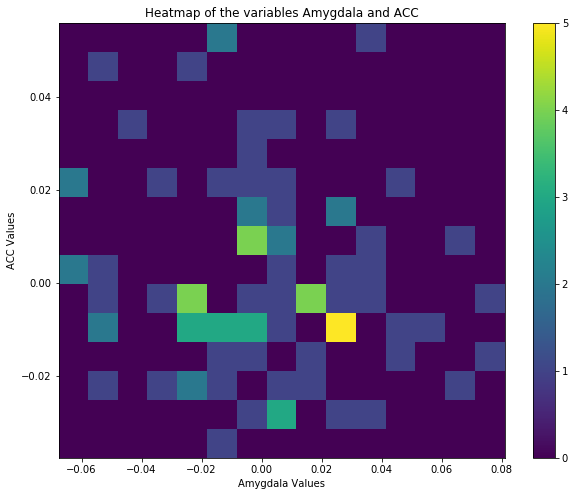

In [27]:
# Plot a colormap histogram of the data.

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax.set_title('Heatmap of the variables Amygdala and ACC')
ax.set_xlabel('Amygdala Values')
ax.set_ylabel('ACC Values')

hist, xedges, yedges, heatmap = hist2d(data[:,0], data[:,1], bins=bins_per_axis)
plt.colorbar(heatmap, ax=ax)

plt.show()

The heatmap makes it easier to see the distribution of the data. There are three areas with a higher concentration of data points, suggesting there may be three modes to the data. This is somewhat surprising since the data represents political orientation of a mainly two-party system. However, this may suggest that a two-party measurement scheme is not sufficient to capture the true variation in political preference.

**b) Now implement kernel-density estimation (KDE) to estimate the 2-dimensional density function of `(amygdala, acc)`.** 

Use a simple multi-dimensional Gaussian kernal, for

$$ \vec x = \left[ \begin{array}{c} x_1 \\ x_2 \end{array} \right] \in \mathbb{R}^2$$

where $x_1$ and $x_2$ are the two dimensions, respectively. 

$$ K(\vec x) = \frac{1}{\sqrt{2\pi}} e^-{\frac{\big (x_1^2 + x_2^2 \big)}{2}}$$

Recall in this case, the kernel density estimator (KDE) for a density is given by

$$ p\,(\vec x) = \frac{1}{m} \sum_{i=1}^{m} \frac{1}{h} K \Big (\frac{\vec x^i - \vec x}{h} \Big) $$

where $\vec x^i$ are two-dimensional vectors, $h > 0$ is the kernel bandwidth. 

Set an appropriate $h$ so you can see the shape of the distribution clearly. Plot a contour plot of your estimated density.

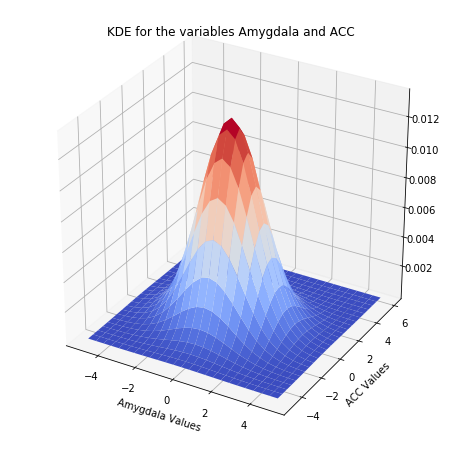

In [110]:
'''
Steps to implementing KDE from scratch...

1. Define the kernel function.

2. Define the KDE estimator function.

3. Define the 2-dimensional space to calculate and plot the KDE values.

4. For each datapoint:
    a. Calculate the KDE value at each point in the space.
    
    b. Add the incremental density to the total for each point in the space
    
5. Create a contour plot of the estimated density
'''

def gaussian(x, h): 
    c = 1/(h*np.sqrt(2*np.pi))
    e = -(1/2) * (x.T @ x) / h**2
    return c*np.exp(e)


def KDE(func, h, data, grid):
    m, n = data.shape
    s = np.zeros(len(grid))
    
    for gridpoint in range(len(grid)):  # Loop through all points in the meshgrid
        for datapoint in range(m):          # Loop through all datapoints in the dataset
            s[gridpoint] += func(grid[gridpoint,:]-data[datapoint,:], h=h)
            
    return s
    
# Define the 2-dimensional space to calculate and plot the KDE-Values 
bins = 25

x1min = np.min(data[0,:])
x1max = np.max(data[0,:])
x2min = np.min(data[1,:])
x2max = np.max(data[1,:])

x1 = np.linspace(round(x1min)-5, round(x1max)+3, bins) 
x2 = np.linspace(round(x2min)-5, round(x2max)+3, bins)
xr, yr = np.meshgrid(x1, x2)

mesh = np.array([xr.flatten(), yr.flatten()]).T    

# Calculate the KDE for each point in the 2-dimensional space
kde = KDE(func=gaussian, h=1.5, data=data[:,0:2], grid=mesh)
kde_norm = kde/sum(kde)
kde_norm = kde_norm.reshape(bins,bins)

# Create a contour plot of the estimated density
fig = plt.figure(figsize=(8,8))
ax=fig.add_subplot(111, projection='3d')
ax.set_title('KDE for the variables Amygdala and ACC')
ax.set_xlabel('Amygdala Values')
ax.set_ylabel('ACC Values')

ax.plot_surface(xr, yr, kde_norm, cmap=cm.coolwarm)
plt.show()

**c) Plot the conditional distribution of the volume of the `amygdala` as a function of political `orientation`. Do the same for the volume of `acc`.**

$p\,(amygdala  \,\, | \,\, orientation = a), a = 1, 2, 3, 4, 5$

$p\,(acc  \,\, | \,\, orientation = a), a = 1, 2, 3, 4, 5$

Actual labels are only: {2.0, 3.0, 4.0, 5.0} 

Conditional Distributions for Amygdala as a function of orientation.
Number of datapoints where a = 2:  13
Number of datapoints where a = 3:  24
Number of datapoints where a = 4:  41
Number of datapoints where a = 5:  12


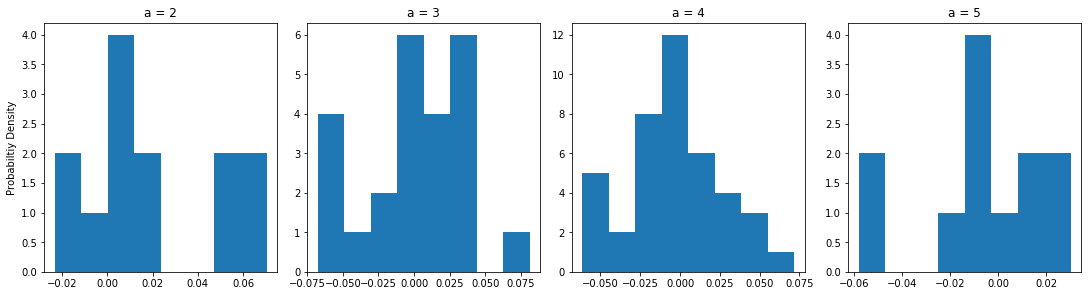

In [185]:
bins = 8

amyg = data[:,0]
acc = data[:,1]
labels = data[:,2]

print('Actual labels are only:', set(labels),'\n')

print('Conditional Distributions for Amygdala as a function of orientation.')
fig, axs = plt.subplots(1, 4, figsize=(15,4), constrained_layout=True)

for a in [2,3,4,5]:

    amyg_c = amyg[np.where(labels == a)]
    print(f'Number of datapoints where a = {a}: ', len(np.where(labels == a)[0]))

    if a == 2:
        axs[a-2].set_ylabel('Probabiltiy Density')

    axs[a-2]    
    axs[a-2].set_title(f'a = {a}')
    axs[a-2].hist(amyg_c, bins=bins)


Actual labels are only: {2.0, 3.0, 4.0, 5.0} 

Conditional Distributions for ACC as a function of orientation.
Number of datapoints where a = 2:  13
Number of datapoints where a = 3:  24
Number of datapoints where a = 4:  41
Number of datapoints where a = 5:  12


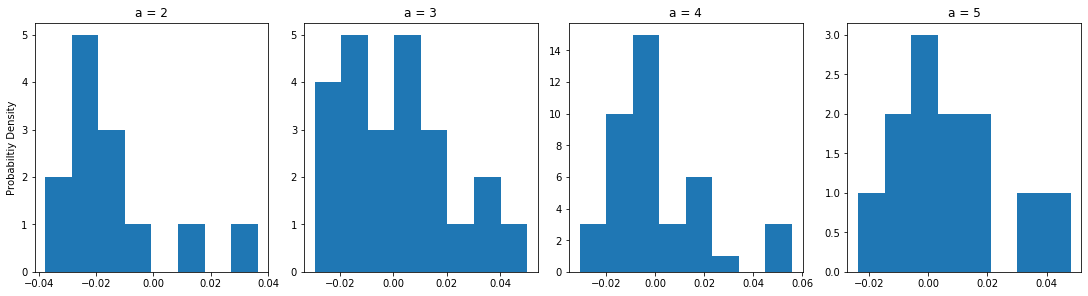

In [187]:
bins = 8

amyg = data[:,0]
acc = data[:,1]
labels = data[:,2]

print('Actual labels are only:', set(labels),'\n')

print('Conditional Distributions for ACC as a function of orientation.')
fig, axs = plt.subplots(1, 4, figsize=(15,4), constrained_layout=True)

for a in [2,3,4,5]:

    acc_c = acc[np.where(labels == a)]
    print(f'Number of datapoints where a = {a}: ', len(np.where(labels == a)[0]))
    
    if a == 2:
        axs[a-2].set_ylabel('Probabiltiy Density')
    
    axs[a-2]    
    axs[a-2].set_title(f'a = {a}')
    axs[a-2].hist(acc_c, bins=bins)


The histograms above show how `Amygdala` and `ACC` are distributed relative to a person's political orientation. 

There were more moderate respondents than people on either edge of the spectrum, and surprisingly 0 respondents were considered 'very-conservative'.

People who were more conservative had smaller `amygdala` and `acc` measurements, as shown by both histograms under `a=2` being skewed left.

People who were more liberal had larger `amygdala` measurements, but no material difference in `acc` measurements, as shown by the amygdala histogram being skewed right in the histogram under `a=5`.

In general, there appears to be a slight correlation between both the `amygdala` and `acc` size, and a person's political orientation. As we move from conservative to liberal, both measurements seem to increase.